In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [17]:
FLAG_DEBUG = False
FLAG_EXPORT = True

# Definition

In [3]:
areas = [
        {'name': 'ginasio', 
         'xi': 200, 'xf': 400, 'yi': 80, 'yf': 400, 'value': 0},
        {'name': 'hall', 
         'xi': 720, 'xf': 850, 'yi': 240, 'yf': 350, 'value': 0},
        {'name': 'alaNorte', 
         'xi': 400, 'xf': 580, 'yi': 380, 'yf': 470, 'value': 0},
        {'name': 'blocoCentral', 
         'xi': 420, 'xf': 620, 'yi': 200, 'yf': 380, 'value': 0}, 
        {'name': 'pracinha', 
         'xi': 600, 'xf': 800, 'yi': 350, 'yf': 450, 'value': 0}, 
        {'name': 'eletroeletronica', 
         'xi': 620, 'xf': 720, 'yi': 150, 'yf': 270, 'value': 0}, 
        {'name': 'edificações', 
         'xi': 720, 'xf': 880, 'yi': 100, 'yf': 200, 'value': 0}
        ]
heatmap = np.zeros((548, 1081))

# Detection

In [4]:
from yoloV3 import *
model = load_model('assets/model.h5') # load yolov3 model

Using TensorFlow backend.
/home/benitez/anaconda3/envs/devCPU/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/benitez/anaconda3/envs/devCPU/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/benitez/anaconda3/envs/devCPU/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/benitez/ana

/home/benitez/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
input_w, input_h = 416, 416 # expected input shape for the model
class_threshold = 0.5 # probability threshold for detected objects
nms = 0.4 #non-maximum supression

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]] # chosen based on an analysis of the size of objects in the MSCOCO dataset

def draw_persons(filename, v_boxes, v_labels):
    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()

    for i in range(len(v_boxes)):
        if v_labels[i]=='person':
            box = v_boxes[i]
            y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
            
            #label = "%.2f" % (v_scores[i])
            #pyplot.text(x1, y1, label, color='red')

In [6]:
for area in areas:
    photo_filename = 'assets/' + area['name'] + '.jpg'

    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    yhat = model.predict(image)

    # decode the output of the network
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    do_nms(boxes, nms)

    # Vizualize
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    print('---------------------------------------------------')
    print ('--------', area['name'], '------------')
    print("Output Shape: ", [a.shape for a in yhat])
    print("Decoded output:")
    for i in range(len(v_boxes)):
        print("  ", v_labels[i], v_scores[i])
    n = sum([label=='person' for label in v_labels])
    print("Number of Persons:", n)
    area['value']=n
    
    #draw_persons(photo_filename, v_boxes, v_labels)

---------------------------------------------------
-------- ginasio ------------
Output Shape:  [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Decoded output:
   person 99.42476749420166
Number of Persons: 1
---------------------------------------------------
-------- hall ------------
Output Shape:  [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Decoded output:
   person 96.48021459579468
   person 99.76182579994202
   person 98.76616597175598
   person 90.77208638191223
   person 94.77919340133667
   handbag 60.135865211486816
   person 82.24965333938599
   person 72.86856174468994
Number of Persons: 7
---------------------------------------------------
-------- alaNorte ------------
Output Shape:  [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Decoded output:
   person 87.11528778076172
Number of Persons: 1
---------------------------------------------------
-------- blocoCentral ------------
Output Shape:  [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 25

---------------------------------------------------
-------- hall ------------
Output Shape:  [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Decoded output:
   person 96.48021459579468
   person 99.76182579994202
   person 98.76616597175598
   person 90.77208638191223
   person 94.77919340133667
   handbag 60.135865211486816
   person 82.24965333938599
   person 72.86856174468994
Number of Persons: 7


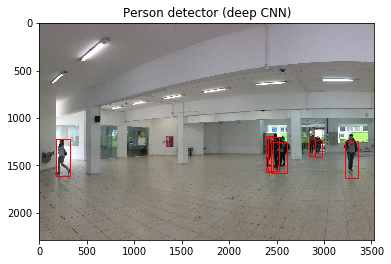

In [20]:
if FLAG_DEBUG or 1:
    area = [area for area in areas if area['name']=='hall'][0]
    photo_filename = 'assets/' + area['name'] + '.jpg'

    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    yhat = model.predict(image)

    # decode the output of the network
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    do_nms(boxes, nms)

    # Vizualize
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    print('---------------------------------------------------')
    print ('--------', area['name'], '------------')
    print("Output Shape: ", [a.shape for a in yhat])
    print("Decoded output:")
    for i in range(len(v_boxes)):
        print("  ", v_labels[i], v_scores[i])
    n = sum([label=='person' for label in v_labels])
    print("Number of Persons:", n)
    area['value']=n
    
    draw_persons(photo_filename, v_boxes, v_labels)
    plt.title("Person detector (deep CNN)")
    if FLAG_EXPORT:
        plt.savefig('assets/vizualizations/hall.svg', format='svg')

In [7]:
if FLAG_DEBUG:
    areaName = 'ginasio'
    # run yolo
    area = [area for area in areas if area['name']==areaName][0]
    area['value']=10

    areaName = 'hall'
    # run yolo
    area = [area for area in areas if area['name']==areaName][0]
    area['value']=60

    areaName = 'alaNorte'
    # run yolo
    area = [area for area in areas if area['name']==areaName][0]
    area['value']=20

    areaName = 'blocoCentral'
    # run yolo
    area = [area for area in areas if area['name']==areaName][0]
    area['value']=60

    areaName = 'pracinha'
    # run yolo
    area = [area for area in areas if area['name']==areaName][0]
    area['value']=30

    areaName = 'eletroeletronica'
    # run yolo
    area = [area for area in areas if area['name']==areaName][0]
    area['value']=30

    areaName = 'edificações'
    # run yolo
    area = [area for area in areas if area['name']==areaName][0]
    area['value']=30

# Heatmap Vizualization

In [8]:
from scipy.ndimage.filters import gaussian_filter

In [9]:
# Manual correction 
areas[2]['value']=3
areas[4]['value']=3
areas[5]['value']=4

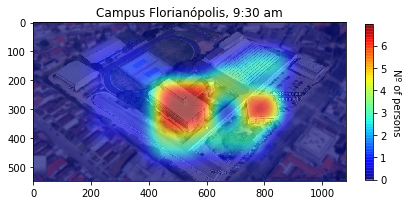

In [18]:
#apply
for area in areas:
    heatmap[area['yi']:area['yf'], area['xi']:area['xf']] = area['value']

#show
img = imageio.imread('assets/fpolis.png')
plt.figure(figsize=(7,7))
plt.imshow(img)

plt.imshow(gaussian_filter(heatmap, sigma=30),cmap="jet",alpha=0.6)
plt.title("Campus Florianópolis, 9:30 am")
cbar = plt.colorbar(shrink=0.41)
cbar.set_label('Nº of persons', rotation=270, labelpad=15)
if FLAG_EXPORT:
    plt.savefig('assets/vizualizations/heatmap.svg', format='svg')